[1.72835025 1.71487083 1.70723688 1.70525826 1.69573119 1.69342646
 1.68850841 1.68596713 1.68172959 1.67764689 1.67293566 1.66791379
 1.66265843 1.66201863 1.65318002 1.65190414 1.64988172 1.6478571
 1.6436171  1.64162515 1.63786503 1.63301955 1.63214993 1.63102192
 1.62425853 1.62388324 1.61741204 1.61615779 1.61458461 1.61343005
 1.60955431 1.60549293 1.60409717 1.59895644 1.59660093 1.59446104
 1.5924557  1.59124958 1.5897443  1.58812936 1.58438803 1.58324447
 1.57797544 1.57673636 1.57529843 1.57182787 1.56915612 1.56844831
 1.56750382 1.56082775 1.55893493 1.55727979 1.55483016 1.55325161
 1.55260388 1.54829361 1.54711977 1.545554   1.54402667 1.54277106
 1.53847224 1.53586631 1.53278061 1.53203386 1.53178536 1.52762173
 1.52751659 1.52548269 1.5217057  1.52125239 1.51833886 1.51772258
 1.51458072 1.51297352 1.51110958 1.50693581 1.5044242  1.50370719
 1.50132993 1.49764954 1.49633276 1.49486338 1.49322338 1.49194273
 1.4890519  1.4876655  1.48663799 1.4841739  1.47950562 1.47860

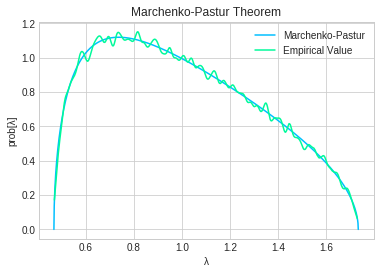

In [6]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity


def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
        var (float): Variance
        q (float): T/N where T is the number of rows and N the number of columns
        pts (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf

def getPCA(matrix):
    """
    Gets the Eigenvalues and Eigenvector values from a Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation matrix
    Returns:
         (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation matrix
            np.ndarray: Eigenvectors of correlation matrix
    """
    # Get eVal,eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

import numpy as np
from scipy.optimize import minimize
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf


def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs x is the array of values
        on which the fit KDE will be evaluated. It is the empirical PDF
    Args:
        obs (np.ndarray): observations to fit. Commonly is the diagonal of Eigenvalues
        bWidth (float): The bandwidth of the kernel. Default is .25
        kernel (str): The kernel to use. Valid kernels are [‘gaussian’|’tophat’|
            ’epanechnikov’|’exponential’|’linear’|’cosine’] Default is ‘gaussian’.
        x (np.ndarray): x is the array of values on which the fit KDE will be evaluated
    Returns:
        pd.Series: Empirical PDF
    """
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

import numpy as np
from scipy.optimize import minimize
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")


# Generating a random matrix
x = np.random.normal(size=(10000,1000))
# Getting eigenvalues and eigenvectors
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
# Marchenko-Pastur pdf
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
# Empirical pdf
pdf1= fitKDE(np.diag(eVal0), bWidth=0.01)

# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")

print(np.diag(eVal0))
print(x.shape[0]/float(x.shape[1]))

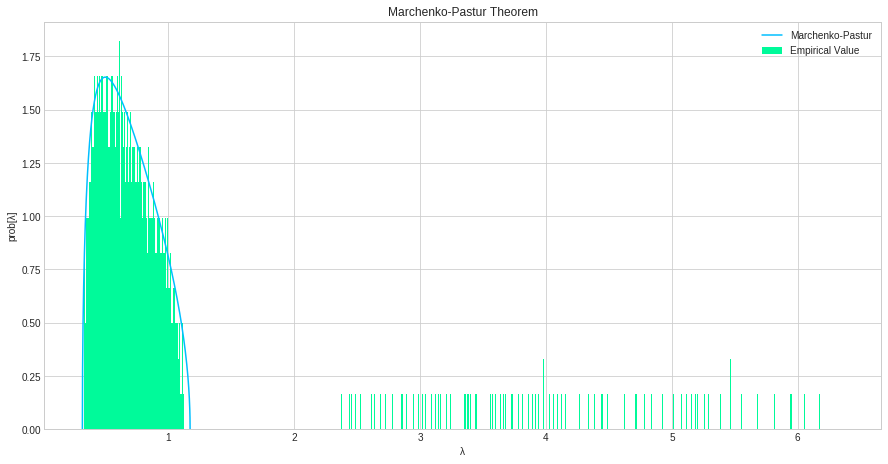

In [3]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf


def getRndCov(nCols, nFacts):
    """
    Generates a Random Covariance Matrix
    Args:
        nCols (int): number of columns of random normal. This will be the dimensions of
            the output
        nFacts (int): number of rows of random normal
    Returns:
        np.ndarray: random covariance matrix
    """
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols))  # full rank cov
    return cov


def cov2corr(cov):
    """
    Derive the correlation matrix from a covariance matrix
    Args:
        cov (np.ndarray): covariance matrix
    Returns:
        np.ndarray: correlation matrix
    """
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr


def errPDFs(var, eVal, q, bWidth, pts=1000):
    """
    Fit error of Empirical PDF (uses Marchenko-Pastur PDF)
    Args:
        var (float): Variance
        eVal (np.ndarray): Eigenvalues to fit.
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
        pts (int): Number of points used to construct the PDF
    Returns:
        float: sum squared error
    """
    # Fit error
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0) ** 2)
    return sse


def findMaxEval(eVal, q, bWidth):
    """
    Find max random eVal by fitting Marchenko’s dist (i.e) everything else larger than
        this, is a signal eigenvalue
    Args:
        eVal (np.ndarray): Eigenvalues to fit on errPDFs
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
    Returns:
         (tuple): tuple containing:
            float: Maximum random eigenvalue
            float: Variance attributed to noise (1-result) is one way to measure
                signal-to-noise
    """

    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth),
                   bounds=((1E-5, 1 - 1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1. / q) ** .5) ** 2
    return eMax, var
  
alpha, nCols, nFact, q = .995, 1000, 100, 10
# Random Matrix
rand_matrix = np.random.normal(size=(nCols * q, nCols))
# Covariance Matrix
cov = np.cov(rand_matrix, rowvar=0)
# Adding signal to Covariance Matrix
cov = alpha * cov + (1 - alpha) * getRndCov(nCols, nFact) # noise + signal
# Converting Covariancce to Correlation
corr0 = cov2corr(cov)
# Getting Eigenvalues and Eigenvectors
eVal0, eVec0 = getPCA(corr0)

# Getting Max Eigenvalues and calculating variance attributed to noise
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

# Getting PDFs and plotting it
pdf0 = mpPDF(var0, q=10, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)  # Empirical PDF

# Plotting PDFs
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue", figsize=(15,7.5))
ax.hist(pd.Series(np.diag(eVal0)), density="norm", bins=1000, label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")
